# Recurrent Neural Networks

### Practical Session

<br/> Prof. Dr. Georgios K. Ouzounis
<br/> email: georgios.ouzounis@go.kauko.lt

<br/> Student: Vygantas Jaras
<br/> email: vygantas.ja9484@go.kauko.lt

## Contents

1. Data loading and pre-processing
2. Building the RNN
3. Train and deploy the RNN
4. Improving the RNN

## Challenge

<img src="https://www.sapientrade.com/images/2017/02/14/AI-Machine-Learning-Trading-Benefits.jpg" width="800" align="left"/>

Given a 10-year history of the Intel Stock prices predict the stock values for the period of the recent most month that are not included in the historical data.

## Data loading and pre-processing

### Download the data-sets

The data-sets are two comma-separated values files (CSV) and contain a data table of 2538 records for training and a table of 22 records for testing.

These data-sets were downloaded from yahoo finances

**Intel_Stock_Price_Test.csv** and **Intel_Stock_Price_Train.csv**



Open a terminal and use the wget command to get it of the selected location. Example:

```shell
wget https://raw.githubusercontent.com/vygantasjaras/RNN/main/Intel_Stock_Price_Test.csv

wget https://raw.githubusercontent.com/vygantasjaras/RNN/main/Intel_Stock_Price_Train.csv 
```


### Import libraries

We need 3 main libraries:

- [Numpy](http://www.numpy.org): it is the fundamental package for scientific computing with Python. It contains among other things a powerful N-dimensional array object that can be used as an efficient multi-dimensional container of generic data. Arbitrary data-types can be defined.
- [matplotlib](https://matplotlib.org):  it is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.
- [pandas](https://pandas.pydata.org): is a software library written for the Python programming language for data manipulation and analysis. In particular, it offers data structures and operations for manipulating numerical tables and time series.

In [30]:
# importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Import the dataset

Dataset description: the open high, low and close values of the Google Stock from 2012 to 2016. [Relevant code here](https://github.com/pdway53/Predict_Google_Stock_Price_RNN)


In [31]:
#importing the dataset

# load the file contents 
dataset_train = pd.read_csv('Intel_Stock_Price_Train.csv')

In [32]:
dataset_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-07-31,19.340000,19.559999,19.250000,19.250000,13.682571,47557600
1,2009-08-03,19.480000,19.559999,19.180000,19.370001,13.767866,44330800
2,2009-08-04,19.209999,19.379999,19.150000,19.320000,13.732331,46880800
3,2009-08-05,19.270000,19.299999,18.860001,18.860001,13.503215,60035000
4,2009-08-06,18.930000,19.180000,18.559999,18.700001,13.388664,66862100


In [33]:
# Create a subtable of relevant entries (open values)
# The .values makes this vector a numpy array
training_set = dataset_train.iloc[:, 1:2].values 

In [34]:
training_set

array([[19.34    ],
       [19.48    ],
       [19.209999],
       ...,
       [52.689999],
       [51.529999],
       [51.709999]])

### Feature Scaling

Next we need to rescale our data to the range from 0 to 1. 

In [35]:
# Feature Scaling

# import the MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

In [36]:
# create a scaler instance to rescale all data to the range of 0.0 to 1.0 
sc = MinMaxScaler(feature_range = (0, 1))

In [37]:
# create the actual training set of scaled values
training_set_scaled = sc.fit_transform(training_set)

In [38]:
training_set_scaled

array([[0.0356011 ],
       [0.0390149 ],
       [0.03243111],
       ...,
       [0.84881736],
       [0.82053158],
       [0.82492075]])

### Splitting the training set to dependent and independent variables

In [39]:
# Creating a data structure with 90 timesteps and 1 output

# the 90 stock prices in the last 3 months before today
X_train = [] 

In [40]:
training_set_scaled.shape

(2516, 1)

In [41]:
# the stock price today
y_train = [] 

In [42]:
# we start from day 90 because that is the first instance allowing us to 
# go back 90 days
for i in range(90, 2516): 
    # 0 is the column ID, the only column in this case.    
    # put the last 90 days values in one row of X_train
    X_train.append(training_set_scaled[i-90:i, 0]) 
    y_train.append(training_set_scaled[i, 0])


In [43]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [44]:
X_train

array([[0.0356011 , 0.0390149 , 0.03243111, ..., 0.0458425 , 0.05632777,
        0.05681541],
       [0.0390149 , 0.03243111, 0.0338942 , ..., 0.05632777, 0.05681541,
        0.05779081],
       [0.03243111, 0.0338942 , 0.02560354, ..., 0.05681541, 0.05779081,
        0.05145089],
       ...,
       [0.89222146, 0.8822239 , 0.87881002, ..., 0.83199222, 0.83150454,
        0.84442816],
       [0.8822239 , 0.87881002, 0.89051458, ..., 0.83150454, 0.84442816,
        0.84881736],
       [0.87881002, 0.89051458, 0.85564501, ..., 0.84442816, 0.84881736,
        0.82053158]])

### Reshaping the Matrix

We need to add a new matrix dimension to accommodate the indicator (predictor). 


If we were to add the stock value of somebody else together with the the past 60 days of Google, we need to change the length of the 3 dimension to  2.  RNN training tables are 3D!!! Read: [Reshaping NumPy Array | Numpy Array Reshape Examples](https://backtobazics.com/python/python-reshaping-numpy-array-examples/)

In [45]:
# Reshaping the data matrix, we retain the 2 original dimensions and add a third of depth=1
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Building the RNN

### RNN initialization

- Import the sequential model from the Keras API;
- Import the Dense layer template from the Keras API;
- Import the LSTM model from the Keras API
- Create an instance of the sequential model called regressor because we want to predict a continuous value

In [46]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [47]:
# Initialising the RNN as a sequence of layers
regressor = Sequential()

### Add First Layer

We first add an object of the LSTM class! 

- The first argument is the number of units or LSTM memory cells. Include many neurons to address the high dimensionality of the problem; say 50 neurons! 
- Second arg: return sequences = true; stacked LSTM !
- Third arg: input 3D shape: observations vs time steps vs number of indicators

In [48]:
# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape =  (X_train.shape[1], 1)))

In [49]:
# the argument is the dropout rate to ignore in the layers (20%), 
# i.e. 50 units * 20% = 10 units will be dropped each time
regressor.add(Dropout(0.2))


### Add More Layers

We can add more LSTM layers but along with Dropout regularization to make sure we avoid overfitting! 

We don’t need to add the shape of the layer again because it is recognized automatically from the number of input units.

The last layer does not return a sequence but connected directly to a fully connected output layer.


In [50]:
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [51]:
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [52]:
# Adding a fourth LSTM layer and some Dropout regularisation
# we removed the return_sequences because we no longer return a 
# sequence but a value instead
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### Add Output Layer & Compile

The output has 1 dimension , i.e. one value to be predicted thus or output fully connected layer has dimensionality = 1.

- **Optimizer**: rmsprop is recommended in the Keras documentation. The Adam optimizer is also a powerful choice.
- **Loss function**: regression problems take the mean square error as most common

In [53]:
# Adding the output layer
regressor.add(Dense(units = 1))

In [54]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Train and deploy the RNN

In [55]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
76/76 [==============================] - 15s 197ms/step - loss: 0.0120
Epoch 2/100
76/76 [==============================] - 15s 191ms/step - loss: 0.0035
Epoch 3/100
76/76 [==============================] - 14s 189ms/step - loss: 0.0034
Epoch 4/100
76/76 [==============================] - 14s 187ms/step - loss: 0.0034
Epoch 5/100
76/76 [==============================] - 14s 187ms/step - loss: 0.0030
Epoch 6/100
76/76 [==============================] - 17s 228ms/step - loss: 0.0028
Epoch 7/100
76/76 [==============================] - 17s 222ms/step - loss: 0.0028
Epoch 8/100
76/76 [==============================] - 16s 214ms/step - loss: 0.0022
Epoch 9/100
76/76 [==============================] - 17s 221ms/step - loss: 0.0024
Epoch 10/100
76/76 [==============================] - 16s 213ms/step - loss: 0.0023
Epoch 11/100
76/76 [==============================] - 16s 213ms/step - loss: 0.0023
Epoch 12/100
76/76 [==============================] - 16s 212ms/step - loss: 0.0020
E

76/76 [==============================] - 12s 159ms/step - loss: 6.9077e-04
Epoch 97/100
76/76 [==============================] - 14s 180ms/step - loss: 7.0016e-04
Epoch 98/100
76/76 [==============================] - 13s 167ms/step - loss: 7.8554e-04
Epoch 99/100
76/76 [==============================] - 12s 158ms/step - loss: 7.4444e-04
Epoch 100/100
76/76 [==============================] - 12s 158ms/step - loss: 7.8024e-04


### Computing Predictions

Create a data-frame by importing the Intel Stock Price Test set for July 2019 using pandas and make it a numpy array.

In [86]:
# Getting the real stock price for July 1st 2019 - 
# July 31st 2019

dataset_test = pd.read_csv('Intel_Stock_Price_Test.csv')
dataset_test

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-08-01,50.520000,51.889999,49.470001,49.500000,48.059563,34020800
1,2019-08-02,49.090000,49.360001,48.500000,48.680000,47.263428,27881600
2,2019-08-05,47.759998,47.959999,46.570000,46.970001,45.603188,38936600
3,2019-08-06,47.150002,47.560001,46.770000,46.959999,45.901310,26119600
4,2019-08-07,46.299999,46.880001,45.970001,46.730000,45.676498,29440400
5,2019-08-08,46.160000,47.369999,45.910000,47.169998,46.106575,30643700
6,2019-08-09,46.939999,47.000000,45.779999,45.980000,44.943405,24975500
7,2019-08-12,45.759998,46.070000,45.439999,45.599998,44.571964,18490300
8,2019-08-13,45.490002,47.049999,45.360001,46.840000,45.784016,28959500
9,2019-08-14,46.060001,46.630001,45.650002,45.869999,44.835884,25650200


In [87]:
real_stock_price = dataset_test.iloc[:, 1:2].values
real_stock_price.size

22

In [99]:
real_stock_price

array([[50.52    ],
       [49.09    ],
       [47.759998],
       [47.150002],
       [46.299999],
       [46.16    ],
       [46.939999],
       [45.759998],
       [45.490002],
       [46.060001],
       [46.099998],
       [46.34    ],
       [47.459999],
       [47.029999],
       [47.110001],
       [47.279999],
       [46.349998],
       [45.82    ],
       [45.869999],
       [45.700001],
       [46.459999],
       [47.240002]])

To predict the stock price value for each day in July 2019, we need the values in the last 90 days.

To obtain this **history** we need to combine both the training and test sets in one.

If we were to use the training_set and test_set we would need to use the scaler  but that would change the actual test values.  Thus concatenate the original data frames!


In [100]:
# Getting the predicted stock price of 2019

# axis = 0 means concatenate the lines (i.e. vertical axis)
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0) 

In [101]:
dataset_total.size


2538

In [102]:
# the difference in the length of the first two gives us 
# the first day in 2019, and we need to go back 90 days to get the necessary range
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 90:].values

In [103]:
inputs.size

112

In [104]:
# we did not use iloc from panda so lets reshape the numpy array for 
# compatibility: i.e. all the values from input lines to be stacked in one 
# column. The -1 means that the numpy has no knowledge of how the 
# values were stored in lines. The 1 means we want to them in one 
# column.

inputs = inputs.reshape(-1,1) 

# apply the feature scaler
inputs = sc.transform(inputs)

In [105]:
# Getting the predicted stock price of 2019
X_test = []

In [106]:
# the first 90 from inputs are from training set; start 
# from 90 and get the extra 20, i.e. up to 112
for i in range(90, 112): 
    X_test.append(inputs[i-90:i, 0])


In [107]:
X_test = np.array(X_test) # not 3D structure yet

In [108]:
# create a 3D structure
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [109]:
predicted_stock_price = regressor.predict(X_test)

In [110]:
# need to inverse the scaling to get meaningful predicted stock price # outputs
predicted_stock_price = sc.inverse_transform(predicted_stock_price) 
predicted_stock_price.size

22

### Result Visualization


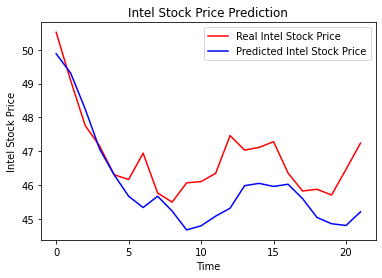

In [111]:
# Visualising the results

plt.plot(real_stock_price, color = 'red', label = 'Real Intel Stock Price')

plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Intel Stock Price')

plt.title('Intel Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Intel Stock Price')
plt.legend()

plt.show()

The blue line shows the trend of the stock for the month of July 2019. 

Some observations:
- The prediction lags behind the actual price curve because the model cannot react to fast non-linear changes. Spikes are examples of fast non-linear changes
- Model reacts pretty well to smooth changes

### Compute the RMSE

If we need to compute the RMSE for our Stock Price Prediction problem, we use the real stock price and predicted stock price as shown.

Then consider dividing this RMSE by the range of the Intel Stock Price values of July 2019 to get a relative error, as opposed to an absolute error. 


In [112]:
#import the libraries
import math
from sklearn.metrics import mean_squared_error

In [114]:
rmse = math.sqrt( mean_squared_error( real_stock_price[0:22,:], predicted_stock_price))
rmse

1.086899795564367